## Illness prediction

In this work we try to reproduce for Italy the results achieved in the article 'Wikipedia Usage Estimates Prevalence of Influenza-Like Illness in the United States in Near Real-Time': in this case, the aim of the experiment is to try to study and predict the time series of the influenza-like illnesses, through the timeseries of the pageviews on the related Wikipedia pages. The data of the illness have been collected through the Italian flu surveillance program called 'Influnet'.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import os, random
from isoweek import Week
from sklearn.preprocessing import scale
from matplotlib.pyplot import rcParams
from sklearn.linear_model import Lasso
from scipy import stats
sb.set_style('darkgrid')

## Part 1 - Data

### 1.1 Wikipedia Data

The webisite called Wikeshark, provides the daily data for the pageviews on all the pages on Wikipedia: such data, gathered from 2010 to 2016, are the object of our analysis. In detail, we focus on the pages related to the illness.

In [3]:
wiki_pages = os.listdir('wikipages')
df_wikipages = None
for page in wiki_pages:
    df = pd.read_csv('wikipages/%s'%page, header = None, usecols = [0,1])
    df.set_index(pd.DatetimeIndex(df[0], freq = 'D'), inplace=True)
    df.drop(0, axis = 1, inplace = True)
    df.columns = [page.split('.')[0]]
    df = df.resample('W-SUN')   
    if df_wikipages is None:
        df_wikipages = df
    else:
        df_wikipages = pd.concat([df_wikipages, df], axis = 1)    

In [4]:
df_wikipages = df_wikipages['2010':]

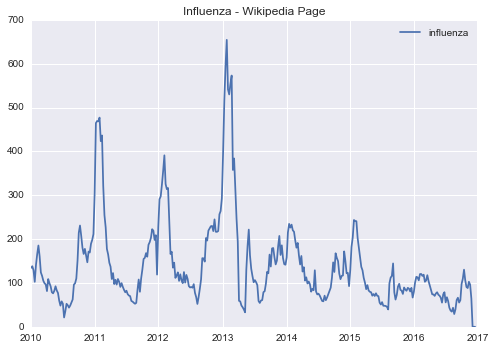

In [5]:
df_wikipages['influenza'].plot()
plt.legend()
plt.title('Influenza - Wikipedia Page')
plt.show()

### 1.2 Influnet Data

The data collected through the Influnet project corresponds to the last flu seasons: each one obviously doesn't cover a whole year. Morover, we are interested only in the column 'incidenza_tot', i.e. the rate of the infected population over the total.

In [6]:
directory = 'influnet/data'
list_files = os.listdir(directory)
str_years = [str(x) for x in range(2010,2017,1)]
list_files = filter(lambda x: any(one_year in x for one_year in str_years), list_files)
columns_csv = pd.read_csv(directory + '/' + list_files[0],' ', nrows = 0).columns.tolist()
columns_csv = columns_csv + ['0_4_casi', '0_4_incidenza', 
                                      '5_14_casi', '5_14_incidenza', 
                                      '15_64_casi', '15_64_incidenza', 
                                      'over65_casi', 'over65_incidenza']
big_influnet = pd.DataFrame(columns=columns_csv)
splitted_reports = []
for single_csv in list_files:
    one_influnet = pd.read_csv(directory + '/' + single_csv, ' ', skiprows=1, header = None, dtype=str)
    if 13 in one_influnet.columns:
        one_influnet.drop(13,axis = 1, inplace = True)
    one_influnet.columns = big_influnet.columns
    big_influnet = pd.concat([big_influnet, one_influnet])
    
    index_influnet = one_influnet['Settimana'].apply(lambda x: Week(int(x.split('-')[0]),int(x.split('-')[1])).sunday())
    one_influnet.set_index(pd.to_datetime(index_influnet), inplace  = True)
    one_influnet.drop('Settimana', axis = 1, inplace=True)
    one_influnet.sort_index(inplace=True)
    splitted_reports.append(one_influnet)

index_influnet = big_influnet['Settimana'].apply(lambda x: Week(int(x.split('-')[0]),int(x.split('-')[1])).sunday())
big_influnet.set_index(pd.to_datetime(index_influnet), inplace  = True)
big_influnet.drop('Settimana', axis = 1, inplace=True)
big_influnet.sort_index(inplace=True)
count = 0
for col in big_influnet.columns.tolist():
            if 'incidenza' in col:
                big_influnet[col] = big_influnet[col].apply(lambda x: float(str(x).replace(',', '.')))
                big_influnet[col].astype('float')
            if 'Medici' in col or 'Tot_assistiti' in col:
                big_influnet[col] = big_influnet[col].apply(lambda x: float(str(x).replace('.', '')))
for small_df in splitted_reports:
    for col in small_df.columns.tolist():
                if 'incidenza' in col:
                    small_df[col] = small_df[col].apply(lambda x: float(str(x).replace(',', '.')))
                    small_df[col].astype('float')
                if 'Medici' in col or 'Tot_assistiti' in col:
                    small_df[col] = small_df[col].apply(lambda x: float(str(x).replace('.', '')))
big_influnet = big_influnet.astype('float')
splitted_new = []
complete_df = pd.concat([df_wikipages, big_influnet], axis =1,join_axes = [df_wikipages.index])
for single_df in splitted_reports:
    new_df = pd.concat([df_wikipages, single_df[['incidenza_tot']]], axis =1,join_axes = [single_df.index])
    new_df.dropna(inplace= True)
    if not new_df.empty:
        splitted_new.append(new_df)
splitted_new = sorted(splitted_new, key = lambda x: sorted(list(set(x.index.year)))[-1])
del splitted_new[0] # remove incomplete df

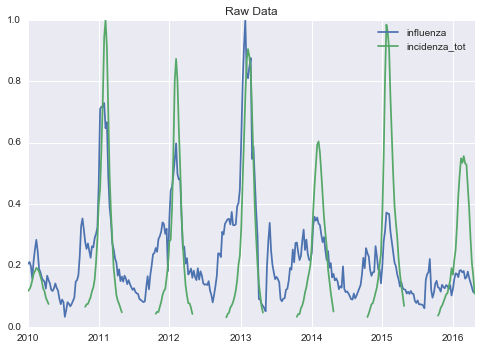

In [7]:
complete_df = complete_df[:'2016-04-24 00:00:00']
(complete_df/complete_df.max())[['influenza', 'incidenza_tot']].plot()
plt.title('Raw Data')
plt.show()

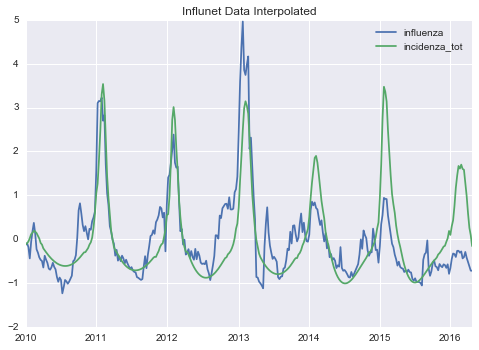

In [8]:
interpolated_incidenza = complete_df.copy()
interpolated_incidenza['incidenza_tot'].interpolate('cubic', inplace = True)
interpolated_incidenza[['influenza', 'incidenza_tot']].apply(scale).plot()
plt.title('Influnet Data Interpolated')
plt.show()

As mentioned before, the data from the the Influnet project are seasonal with respect to the illness, i.e. the time series doesn't cover a whole calendar year. Because of this, the data has been interpolated in order to scale and compare both the time series. The interpolated series have been plotted after the raw data: in both cases it's easy to see that the two time series seem having the same trend: this evidence is stronger in the case of the scaled data.

In [9]:
def take_lag_ts(dataframe,order = 0,delay = 2):
    if order == 0:
        shifted = dataframe.influenza.values
        no_moved = dataframe.incidenza_tot.values
    else:
        no_moved = dataframe.influenza.values
        shifted = dataframe.incidenza_tot.values
    if delay != 0:        
        no_moved = no_moved[delay:]
        shifted = shifted[:-delay]
        return no_moved, shifted
    else:
        return no_moved, shifted       

In [10]:
lag_max = 4
heatmap = pd.DataFrame(columns = range(0,lag_max))
significance_map = pd.DataFrame(columns = range(0,lag_max))

In [11]:
for single_df in splitted_new:
    array_correlations = []
    array_sign = []
    for lag in range(0,lag_max):
        fixed_ts, shifted_ts = take_lag_ts(single_df[['influenza', 'incidenza_tot']].diff().dropna(),order = 0, delay = lag)
        single_corr = stats.pearsonr(fixed_ts, shifted_ts)
        array_correlations.append(single_corr[0])
        array_sign.append(single_corr[1])
    heatmap = heatmap.append(pd.DataFrame([array_correlations], 
                                      index = [str(sorted(list(set(single_df.index.year))))],
                                      columns = heatmap.columns.tolist()))
    significance_map = significance_map.append(pd.DataFrame([array_sign], 
                                      index = [str(sorted(list(set(single_df.index.year))))],
                                      columns = significance_map.columns.tolist()))

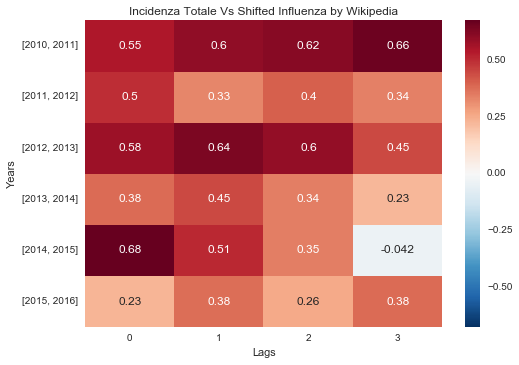

In [12]:
sb.heatmap(heatmap, annot = True)
plt.xlabel('Lags')
plt.ylabel('Years')
plt.title("Incidenza Totale Vs Shifted Influenza by Wikipedia")
plt.show()

Now, to study the correlation between the time series we have chosen to compute the correlation of the incidence in the different seasons with the shifted version of the page 'Influenza': in other words, we're looking for some long or short term effect of the Wikipedia pages on the Influnet data. The above heatmap points out that twice the stronger correlation is in the real time, otherwise when the Wikipedia page is shifted by one week (4 times). This means that, in this case, there's a short term effect that may be useful for the forecasting.

This is the formula applied for the lagged correlation, with $l$ as lag:

$$\rho_{x, y}(l) = \frac{\sum_{t = l+1}^n (x_t - \bar{x})(y_{t-l} - \bar{y})}
{\sqrt{\sum_{t = l+1}^n (x_t - \bar{x})^2 }\sqrt{\sum_{t = 1}^{n-l} (y_t - \bar{y})^2 }}$$

For testing the significance of the correlation we use the test with the following Hypothesis:

$$H_o: \rho = 0$$
$$H_1: \rho \neq 0$$

With the statistic t: 
$$t = \frac{\rho \sqrt{n-2}}{\sqrt{1 -r^2}}$$

In [13]:
significance_map[significance_map > 0.05] = 1 # correlation is significative == 0
significance_map[significance_map <= 0.05] = 0 # correlation is significative != 0

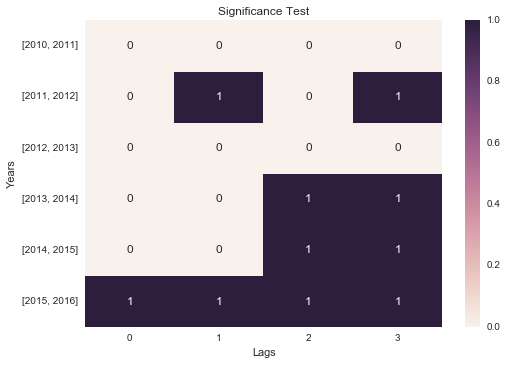

In [14]:
sb.heatmap(significance_map, annot = True)
plt.xlabel('Lags')
plt.ylabel('Years')
plt.title("Significance Test")
plt.show()

The plot above summarizes the results obtained by the test: the 'zero' label means that the Pearson correlation is significantly different from zero. All the correlations mentioned before, with lags equal to 0 or 1, are significant, except for the last season. Indeed in that case, the two time series look less similar than in the past.

## Part 2 - Exploting Wikipedia 

### 2.1 Increase bunch ok Wikipages
Now, to keep on with the analysis, we have selected other Wikipedia Pages in order to compare them with the Influnet data. After searching common queries as 'Influenza' or 'Febbre', we have looked for relevant pages using either the query suggest by the search engine Google or surfing on Wikipedia through the mentioned pages on the famous ones. Since that, the Influnet Data are the Ground Truth of the analysis, we choose to aggregate the seasons over the time in a unique series: this allows to focus only on the epidemic, comparing the data with the Wikipedia pages in the same period.

In [15]:
plot_all = pd.concat([df_wikipages, 
                      big_influnet[['incidenza_tot']]], 
                     axis = 1,
                     join_axes = [big_influnet[['incidenza_tot']].index])

In [16]:
plot_all = plot_all.dropna()

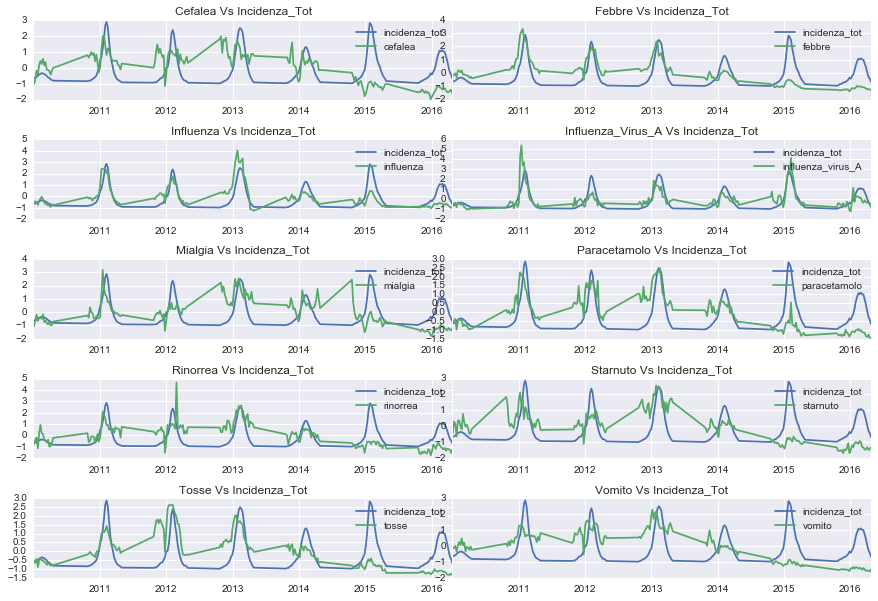

In [17]:
fig, axs = plt.subplots(5,2, figsize=(15, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for idx, page in enumerate(plot_all.columns.tolist()):
    if page != 'incidenza_tot':        
        one_plot = plot_all[['incidenza_tot', page]].apply(scale)
        axs[idx].plot(one_plot)
        axs[idx].legend(one_plot)
        axs[idx].set_title((page + ' Vs ' + 'incidenza_tot').title())

As shown in the plots above, not all the pages have the same trend of the Ground Truth ('incidenza_tot' of the Influnet Data): this means that external effects may affect the pageviews of all the pages. Moreover, it's not clear, only looking at the plot, which Wikipedia time series have to be removed and which not in order to find out the more relevant ones. Even if we can find out no-evidence, it looks easy to claim that some trend are similar to the Ground Truth like 'influenza', 'influenza_virus_A' and 'febbre'.

### 2.2 Comparison

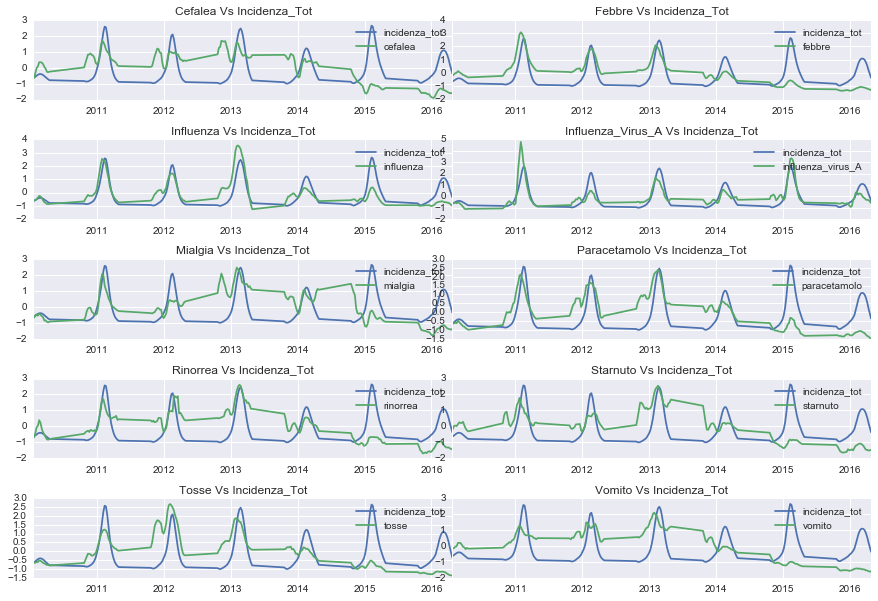

In [18]:
fig, axs = plt.subplots(5,2, figsize=(15, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for idx, page in enumerate(plot_all.columns.tolist()):
    if page != 'incidenza_tot':        
        one_plot = pd.rolling_mean(plot_all[['incidenza_tot', page]], 4).dropna().apply(scale)
        axs[idx].plot(one_plot)
        axs[idx].legend(one_plot)
        axs[idx].set_title((page + ' Vs ' + 'incidenza_tot').title())

In order to find out some clear effect or trend over all the seasons, we have applied a simple moving average to obtain montly data. This tranformation removing the noise, smoothing the time series, shows a clear decreasing pageviews trend on all the Wikipedia pages over the time.

### 2.3 Study of the correlations

In [19]:
for col in df_wikipages.columns:
    print '---'
    corr, p_value = stats.pearsonr(plot_all[col], plot_all['incidenza_tot'])
    corr = round(corr,2)
    if p_value <= 0.05:
        print 'The correlation is significantly different from zero for the %s - TimeSeries with a value equal to %s'%(col,
                                                                                                         corr)
    else:
        print 'The correlation IS NOT significantly different from zero for the %s'%col

---
The correlation IS NOT significantly different from zero for the cefalea
---
The correlation is significantly different from zero for the febbre - TimeSeries with a value equal to 0.46
---
The correlation is significantly different from zero for the influenza - TimeSeries with a value equal to 0.67
---
The correlation is significantly different from zero for the influenza_virus_A - TimeSeries with a value equal to 0.72
---
The correlation is significantly different from zero for the mialgia - TimeSeries with a value equal to 0.26
---
The correlation is significantly different from zero for the paracetamolo - TimeSeries with a value equal to 0.43
---
The correlation is significantly different from zero for the rinorrea - TimeSeries with a value equal to 0.35
---
The correlation is significantly different from zero for the starnuto - TimeSeries with a value equal to 0.24
---
The correlation is significantly different from zero for the tosse - TimeSeries with a value equal to 0.35
---

In this case, we compute the same correlation computed above, considering now no-difference for the seasons, aggregating all the incidence in a unique time series, in order to compare the correlations of the whole Ground Truth with each Wikipedia page. The heatmap below shows that the time series more correlated are 'influenza', 'influenza_virus_A', 'febbre' and 'paracetamolo'. They all have a significant correlation, except for the 'cefalea' one: it even has the lower correlation.

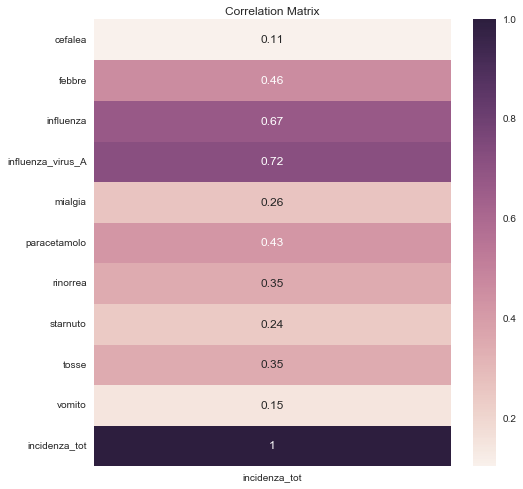

In [20]:
# correlation matrix between covariates
rcParams['figure.figsize'] = (8, 8) 
sb.heatmap(plot_all.corr()[['incidenza_tot']], annot = True)
plt.title("Correlation Matrix")
plt.show()

Focusing only on the Wikipedia Pages, analyzing the correlations among them, it's important to point out that there are not clear patterns but outliers. Two of them are 'influenza_virus_A' and 'influenza' : remarked these as ones of the most correlated with the Ground Truth, they look like not strong correlated with almost all the other pages.

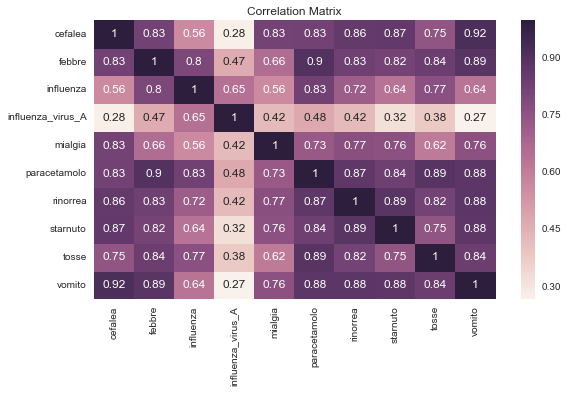

In [21]:
# correlation matrix between covariates
rcParams['figure.figsize'] = (9, 5) 
sb.heatmap(df_wikipages.corr(), annot = True)
plt.title("Correlation Matrix")
plt.show()

## 3 - Methods and Results

### 3.1 Without lagged covariates

In this section, it has been built the Lasso linear model: this one has been chosen because, before performing the prediction of the dependent variable, performs a feature selection on the covariates in order to remove all the possible external effects/trends. 

In detail, the Lasso minimizes the following equation:
$$ \frac{1}{N} \sum_i^N (y_i - \beta_0 - x_i^T \beta)^2$$
with costraint:
$$\sum_j^p |\beta_j| < \alpha$$

Where the constraint is used to find out which covariates affect more than the others the $y$.

To apply the model first of all, we have splitted the dataset in Train and Test, where the latter one is formed by the last season (2015-2016). Then we have run on the Train a 5-fold Cross validation in order to find the optimal value for $\alpha$.

In [58]:
def lasso_regression(sequence_train, test_idx,alpha):
    #Fit the model
    train = [x for idx, x in enumerate(sequence_train) if idx!= test_idx]
    test = sequence_train[test_idx]
    data = reduce(lambda x,y: pd.concat([x,y]), train)
    lassoreg = Lasso(alpha=alpha, max_iter=1e5, fit_intercept= True)
    lassoreg.fit(data[df_wikipages.columns],data['incidenza_tot'])
    y_pred = lassoreg.predict(test[df_wikipages.columns])    
    #Return the result in pre-defined format
    rss = sum((y_pred-test['incidenza_tot'])**2)
    return rss, lassoreg.coef_

In [59]:
sequence_train = splitted_new[:-1]
sequence_test = splitted_new[-1]
seq_alpha = [x for x in np.arange(1,100)]
seq_alpha = sorted([10**-x for x in range(10)]) + seq_alpha
col = ['Test_CV%d'%i for i in range(5)]
ind = ['alpha_%.2g'%alpha for alpha in seq_alpha]
coef_matrix_lasso = pd.DataFrame(index=ind, columns=col)
# perform a lasso with 5 - cross validation 
for one_alpha in seq_alpha:
    for idx in range(5):
        one_rss = lasso_regression(sequence_train,idx, one_alpha)
        coef_matrix_lasso['Test_CV%s'%idx]['alpha_%s'%one_alpha] = one_rss[0]

alpha_23


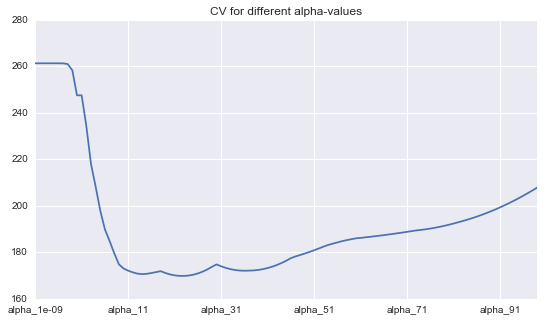

In [63]:
# best alpha
coef_matrix_lasso.mean(axis = 1).plot()
plt.title('CV for different alpha-values')
print coef_matrix_lasso.mean(axis = 1).idxmin()

In [61]:
# Final result
data = reduce(lambda x,y: pd.concat([x,y]), sequence_train)
lasso = Lasso(alpha = 23, max_iter=1e5, fit_intercept=False)
lasso.fit(data[df_wikipages.columns], data['incidenza_tot'])
estimated = lasso.predict(sequence_test[df_wikipages.columns])
print 'Lasso score:'
print np.mean((sequence_test['incidenza_tot'].values - estimated)**2)

Lasso score:
4.76931634064


In [62]:
selected_cov = pd.DataFrame(lasso.coef_, index = df_wikipages.columns, columns = ['Beta'])
print selected_cov[selected_cov != 0].dropna()

                  Beta
febbre        0.001939
influenza     0.017487
paracetamolo  0.000410
vomito       -0.007810


The model has yielded only 4 coefficients different from zero, where the 3 of them are in the set of pages with an high correlation with the incidence: 'febbre','influenza' and 'paracetamolo'.

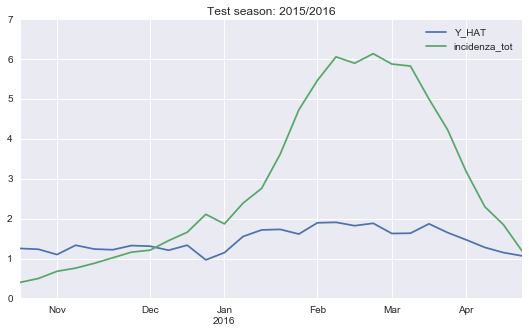

In [31]:
pd.concat([pd.DataFrame(estimated, index = [sequence_test.index], columns = ['Y_HAT']),
           sequence_test['incidenza_tot']], axis = 1).plot()
plt.title('Test season: 2015/2016')

plt.show()

The plot above shows the result obtained running the optimal model on the Test (season 2015-2016): the estimates are completely different from the true values. It might be connected to the lower correlations between the pages and the incidence in the last season. So, since that the activity of all the pages in the last season is less than in the others, we have run another time the model, using a different selection for Train and Test.

In [65]:
sequence_train = [x for idx, x in enumerate(splitted_new) if idx!= 1]
sequence_test = splitted_new[1]
seq_alpha = [x for x in np.arange(1,100)]
seq_alpha = sorted([10**-x for x in range(10)]) + seq_alpha
col = ['Test_CV%d'%i for i in range(6)]
ind = ['alpha_%.2g'%alpha for alpha in seq_alpha]
coef_matrix_lasso = pd.DataFrame(index=ind, columns=col)
# perform a lasso with 5 - cross validation 
for one_alpha in seq_alpha:
    for idx in range(5):
        one_rss = lasso_regression(sequence_train, idx, one_alpha)
        coef_matrix_lasso['Test_CV%s'%idx]['alpha_%s'%one_alpha] = one_rss[0]

alpha_24


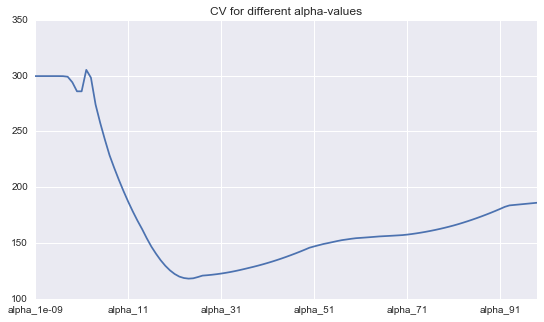

In [66]:
# best alpha
coef_matrix_lasso.mean(axis = 1).plot()
plt.title('CV for different alpha-values')
print coef_matrix_lasso.mean(axis = 1).idxmin()

Lasso score:
2.60847381705


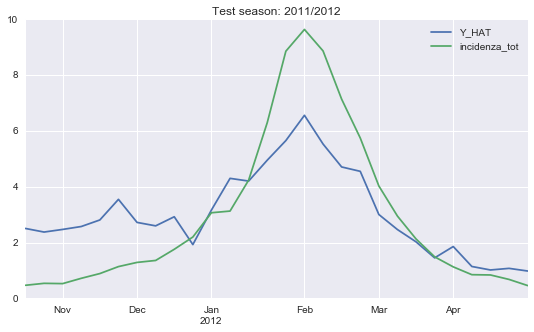

In [68]:
# Final result
data = reduce(lambda x,y: pd.concat([x,y]), sequence_train)
lasso = Lasso(alpha = 24, max_iter=1e5, fit_intercept=False)
lasso.fit(data[df_wikipages.columns], data['incidenza_tot'])
estimated = lasso.predict(sequence_test[df_wikipages.columns])
print 'Lasso score:'
print np.mean((sequence_test['incidenza_tot'].values - estimated)**2)
pd.concat([pd.DataFrame(estimated, index = [sequence_test.index], columns = ['Y_HAT']),
           sequence_test['incidenza_tot']], axis = 1).plot()
plt.title('Test season: 2011/2012')
plt.show()

In [51]:
selected_cov = pd.DataFrame(lasso.coef_, index = df_wikipages.columns, columns = ['Beta'])
print selected_cov[selected_cov != 0].dropna()

                  Beta
influenza     0.017554
paracetamolo  0.000069
vomito       -0.001992


In this case, as we can see, the achieved results are better: i.e. the model is able to predict the trend and achieves a better score.

Remarks, for the meaning of the score:
$$RSS = \frac{\sum_i^N (y_i - \hat{y}_i)^2}{N}$$

### 3.2 With lagged covariates

In the last section, in order to improve our model, we have included the following features: 
- the Influnet incidence for the week preceding the target week
- the pageview counts for the all the pages for the week preceding the target week


In [69]:
dfs = []
for df in splitted_new:
    shifted = df.shift(1)
    shifted.columns = [x + '_shifted' for x in shifted.columns]
    new_merged_df = pd.concat([shifted, df], axis = 1).dropna()
    dfs.append(new_merged_df)
covariates_merged = filter(lambda x: x!= 'incidenza_tot', dfs[0].columns)

In [70]:
def lasso_regression_shifted(seq, test_idx,alpha):
    #Fit the model
    train = [x for idx, x in enumerate(seq) if idx!= test_idx]
    test = seq[test_idx]
    data_cv = reduce(lambda x,y: pd.concat([x,y]), train)
    lassoreg = Lasso(alpha=alpha, max_iter=1e5, fit_intercept= True)
    lassoreg.fit(data_cv[covariates_merged],data_cv['incidenza_tot'])
    y_pred = lassoreg.predict(test[covariates_merged])    
    #Return the result in pre-defined format
    rss = sum((y_pred-test['incidenza_tot'])**2)
    return rss, lassoreg.coef_

In [71]:
sequence_train = [x for idx, x in enumerate(dfs) if idx!= 1]
sequence_test = dfs[1]
seq_alpha = [x for x in np.arange(1,100)]
seq_alpha = sorted([10**-x for x in range(10)]) + seq_alpha
col = ['Test_CV%d'%i for i in range(5)]
ind = ['alpha_%.2g'%alpha for alpha in seq_alpha]
coef_matrix_lasso = pd.DataFrame(index=ind, columns=col)
# perform a lasso with 5 - cross validation 
for one_alpha in seq_alpha:
    for idx in range(5):
        one_rss = lasso_regression_shifted(sequence_train, idx, one_alpha)
        coef_matrix_lasso['Test_CV%s'%idx]['alpha_%s'%one_alpha] = one_rss[0]

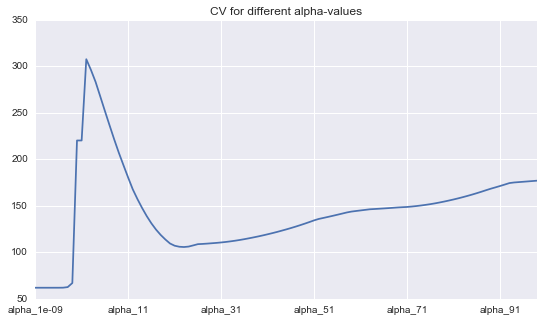

In [75]:
plt.title('CV for different alpha-values')

coef_matrix_lasso.mean(1).plot()
plt.show()

Since that with values too small there's overfitting, as we can see from the plot above, we choose to select the $\alpha$ from the interval [1,100]

In [76]:
sequence_train = [x for idx, x in enumerate(dfs) if idx!= 1]
sequence_test = dfs[1]
seq_alpha = [x for x in np.arange(1,100)]
col = ['Test_CV%d'%i for i in range(5)]
ind = ['alpha_%.2g'%alpha for alpha in seq_alpha]
coef_matrix_lasso = pd.DataFrame(index=ind, columns=col)
# perform a lasso with 5 - cross validation 
for one_alpha in seq_alpha:
    for idx in range(5):
        one_rss = lasso_regression_shifted(sequence_train, idx, one_alpha)
        coef_matrix_lasso['Test_CV%s'%idx]['alpha_%s'%one_alpha] = one_rss[0]

In [77]:
# best alpha
print coef_matrix_lasso.mean(axis = 1).idxmin()

alpha_23


Lasso score:
2.50434810192


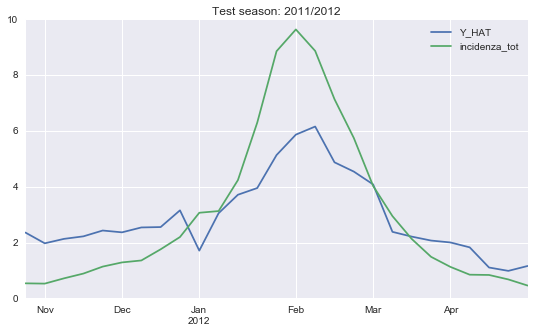

In [78]:
# Final result
data = reduce(lambda x,y: pd.concat([x,y]), sequence_train)
lasso = Lasso(alpha = 23, max_iter=1e5, fit_intercept=True)
lasso.fit(data[covariates_merged], data['incidenza_tot'])
estimated = lasso.predict(sequence_test[covariates_merged])
print 'Lasso score:'
print np.mean((sequence_test['incidenza_tot'].values - estimated)**2)
pd.concat([pd.DataFrame(estimated, index = [sequence_test.index], columns = ['Y_HAT']),
           sequence_test['incidenza_tot']], axis = 1).plot()
plt.title('Test season: 2011/2012')
plt.show()

In [46]:
selected_cov = pd.DataFrame(lasso.coef_, index = covariates_merged, columns = ['Beta'])
print selected_cov[selected_cov != 0].dropna()

                          Beta
influenza_shifted     0.013224
paracetamolo_shifted  0.000312
vomito_shifted       -0.000116
influenza             0.004535
paracetamolo          0.002122
vomito               -0.007939


Using the same pair Train/Test, the estimates and the score are improved. Looking at the correlations at different lags computed before. that result is reasonable: the short-term effect, pointed out before by means of the correlations at different lags, is in the feature selection applied in the last model; for each one selected 'influenza', 'paracetamolo' and 'vomito', the model has chosen also the shifted version and nothing else. So, the model has caught the same effects, found out before, at different lags.

Another crucial point at the end of the analysis is related the feature selection as well: 'infleunza', 'vomito' and 'paracetamolo' are in all the previous configurations. Such evidence means that the Lasso model has caught only the linear relations in the data. So, going further, it may be interesting applying a non-linear model, to look for other kind of connections between the Pageviews on Wikipedia and the Influnet Data.